In [3]:
!pip install transformers
!pip install tensorflow
!pip install torch

  Using cached tensorflow-2.6.2-cp36-cp36m-manylinux2010_x86_64.whl (458.3 MB)
  Using cached clang-5.0-py3-none-any.whl
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached keras-2.6.0-py2.py3-none-any.whl (1.3 MB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
     |████████████████████████████████| 881.9 MB 6.6 kB/s              


In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, TFBertModel
import pandas as pd
import numpy as np
#import datasets
import tensorflow as tf
import torch
import json
import os
from datetime import datetime
import re

In [5]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")



Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [6]:
df=pd.read_csv('sample_drugs.csv' )

In [7]:
df.loc[df['rating'].isin([1,2]),'nps']=0
df.loc[df['rating'].isin([3,4,5,6,7,8]),'nps']=1
df.loc[df['rating'].isin([9,10]),'nps']=2

In [8]:
def clean_text(text):
    text=text.lower()
    text=re.sub(r'\d+', '', text)
    text=re.sub('[^A-Za-z ]+', '',text)
    text=re.sub(' +',' ', text)
    return text

In [9]:
df['review']=df['review'].apply(clean_text)


In [10]:
arr = df['nps'].astype(int).values

labels= np.zeros((len(df), int(df.nps.max())+1))
labels[np.arange((len(df))), arr] = 1
labels, arr

(array([[0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        ...,
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.]]),
 array([1, 0, 2, ..., 2, 1, 0]))

In [11]:
seq_len = 200
num_samples = len(df)
Xids = np.zeros((num_samples, seq_len))
Xmask = np.zeros((num_samples, seq_len))


In [12]:
for i, phrase in enumerate(df['review']): 
    tokens = tokenizer.encode_plus(phrase, 
                                   max_length=seq_len, 
                                   truncation=True,
                                   padding="max_length", 
                                   add_special_tokens=True, 
                                   return_tensors="tf")
    Xids[i, :] = tokens["input_ids"]
    Xmask[i, :] = tokens["attention_mask"]

In [13]:
df.nps.value_counts()

2.0    2477
1.0    1624
0.0     899
Name: nps, dtype: int64

In [14]:
Xids.shape, Xmask.shape, labels.shape

((5000, 200), (5000, 200), (5000, 3))

# Creates dataset

In [15]:
data = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

In [16]:
data.take(1)

<TakeDataset shapes: ((200,), (200,), (3,)), types: (tf.float64, tf.float64, tf.float64)>

In [17]:
def map_function(input_ids, mask, labels): 
    return {
        "input_ids": input_ids, 
        "attention_mask":mask
    }, labels

In [18]:
dataset=data.map(map_function)

In [19]:
split = 0.9
batch_size=8
size = int((num_samples/batch_size) * split)
dataset = dataset.shuffle(10000).batch(batch_size=batch_size, drop_remainder=True)

In [20]:
train_ds = dataset.take(size)
validation_ds = dataset.skip(size)

del dataset

In [21]:
bert = TFBertModel.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFBertModel: ['classifier', 'pre_classifier', 'distilbert', 'dropout_19']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized: ['bert']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
bert.summary()

Model: "tf_bert_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
Total params: 109,482,240
Trainable params: 109,482,240
Non-trainable params: 0
_________________________________________________________________


In [28]:
input_ids = tf.keras.layers.Input(shape=(seq_len,), name="input_ids", dtype="int32")
mask = tf.keras.layers.Input(shape=(seq_len,), name="attention_mask", dtype="int32")

embeddings = bert.bert(input_ids, attention_mask=mask)[1]

x = tf.keras.layers.Dense(512, activation="relu")(embeddings)
drop=tf.keras.layers.Dropout(.2)(x)
y = tf.keras.layers.Dense(3, activation="softmax", name="outputs")(drop)

In [32]:
model = tf.keras.Model(inputs=[input_ids, mask],outputs=y)


model.layers[2].trainable=False

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 200)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 200)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          393728      bert[1][1]                 

In [33]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, decay=1e-5)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy("accuracy")


In [34]:
model.compile(
    optimizer=optimizer, 
    loss = loss, 
    metrics=[acc]
)

In [35]:
from datetime import datetime


In [ ]:
checkpoint_path = "./training/"+str(datetime.today())+"/cp_bert.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 mode='max',
                                                 monitor='val_auc',
                                                 
                                                 verbose=1)

callback_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(
    train_ds, 
    validation_data=validation_ds, 
    epochs=10,
    callbacks=[cp_callback,callback_stop]
)


Epoch 1/10
138/562 [======>.......................] - ETA: 7:40 - loss: 1.0517 - accuracy: 0.4783

In [46]:
history.history

{'loss': [1.0508744716644287,
  1.0352120399475098,
  1.0328500270843506,
  1.0342340469360352,
  1.0288159847259521,
  1.0281137228012085,
  1.026794672012329,
  1.0217945575714111,
  1.0295273065567017,
  1.0243226289749146],
 'accuracy': [0.4701957404613495,
  0.4846530258655548,
  0.4846530258655548,
  0.4866548180580139,
  0.4951067566871643,
  0.48843416571617126,
  0.4915480315685272,
  0.49354982376098633,
  0.4924377202987671,
  0.4979982078075409],
 'val_loss': [1.0392259359359741,
  1.0330675840377808,
  1.0357931852340698,
  1.02452552318573,
  1.038245677947998,
  0.9997830986976624,
  1.0180097818374634,
  1.0032837390899658,
  1.0324679613113403,
  1.0215166807174683],
 'val_accuracy': [0.3849206268787384,
  0.4841269850730896,
  0.4861111044883728,
  0.4801587164402008,
  0.4841269850730896,
  0.5178571343421936,
  0.5317460298538208,
  0.511904776096344,
  0.4861111044883728,
  0.4980158805847168]}

In [48]:
history_dict = history.history
# Save it under the form of a json file
#json.dump(history_dict, open(checkpoint_dir+'/hist.json', 'w'))


In [49]:
import matplotlib.pyplot as plt

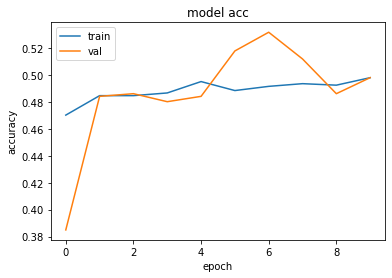

In [55]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.savefig(checkpoint_dir+'/val_ac_'+str(history.history['val_accuracy'][-1])+'.png')
plt.show()


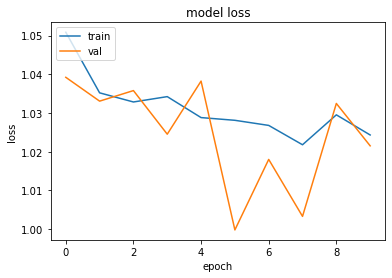

In [54]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.savefig(checkpoint_dir+'/val_loss_'+str(history.history['val_loss'][-1])+'.png')
plt.show()